In [15]:
import torch
from tqdm import tqdm
from PIL import Image
from torch import optim
from torch.nn import Sequential,Linear,Sigmoid,BCELoss,MSELoss,Tanh,Conv2d,MaxPool2d,ReLU,Flatten,Dropout
import  numpy as np
from torchsummary import summary
import os
import matplotlib.pyplot as plt

**Downloading the data**

In [2]:
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d ashishjangra27/gender-recognition-200k-images-celeba

100% 1.32G/1.32G [00:47<00:00, 28.8MB/s]
100% 1.32G/1.32G [00:47<00:00, 29.9MB/s]


In [4]:
!unzip -x /content/gender-recognition-200k-images-celeba.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Validation/Male/189674.jpg  
  inflating: Dataset/Validation/Male/189675.jpg  
  inflating: Dataset/Validation/Male/189676.jpg  
  inflating: Dataset/Validation/Male/189679.jpg  
  inflating: Dataset/Validation/Male/189681.jpg  
  inflating: Dataset/Validation/Male/189684.jpg  
  inflating: Dataset/Validation/Male/189688.jpg  
  inflating: Dataset/Validation/Male/189689.jpg  
  inflating: Dataset/Validation/Male/189691.jpg  
  inflating: Dataset/Validation/Male/189692.jpg  
  inflating: Dataset/Validation/Male/189693.jpg  
  inflating: Dataset/Validation/Male/189694.jpg  
  inflating: Dataset/Validation/Male/189695.jpg  
  inflating: Dataset/Validation/Male/189696.jpg  
  inflating: Dataset/Validation/Male/189697.jpg  
  inflating: Dataset/Validation/Male/189698.jpg  
  inflating: Dataset/Validation/Male/189702.jpg  
  inflating: Dataset/Validation/Male/189704.jpg  
  inflating: Dataset/Validation/Male/189705.jpg  

Reading images of females

In [16]:
files=os.listdir("/content/Dataset/Train/Female")
f=[]
for file in files[:25000]:
    img=Image.open("/content/Dataset/Train/Female/"+file).resize((64,64))
    img=np.array(img).reshape((3,64,64))
    f.append(img)

 

Reading images of maels

In [17]:
m=[]
files=os.listdir("/content/Dataset/Train/Male")
for file in files[:25000]:
    img=Image.open("/content/Dataset/Train/Male/"+file).resize((64,64))
    img=np.array(img).reshape((3,64,64))
    m.append(img)

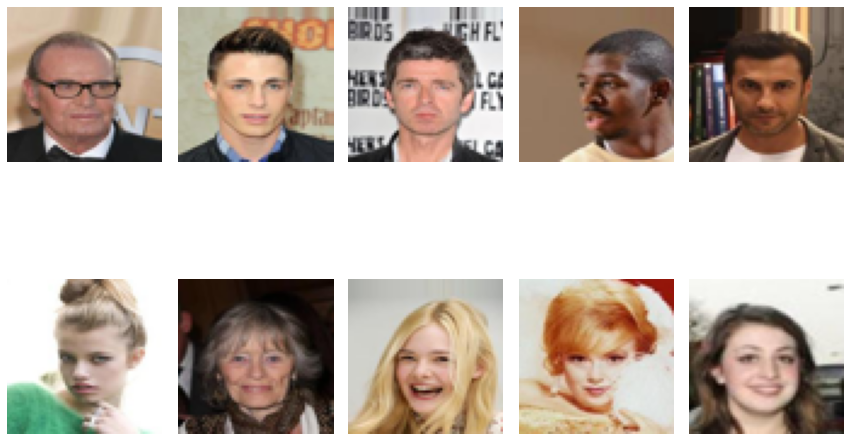

In [18]:
tmp=m[:5]+f[:5]
plt.figure(figsize=(15,10))
for j in range(1,11):
  plt.subplot(2,5,j)
  plt.axis("off")
  plt.imshow(tmp[j-1].reshape((64,64,3)))

plt.subplots_adjust(hspace=0, wspace=0.1)
plt.show()



slicing data into three pieces including train,validation and test

In [20]:


ix_train=int(len(m)*0.6)
ix_val=int(len(m)*0.2)
x_train=m[:ix_train]
x_val=m[ix_train:ix_train+ix_val]
x_test=m[ix_train+ix_val:]
y_train=[[0] for i in range(ix_train)]
y_val=[[0] for i in range(ix_val)]
y_test=[[0] for i in range(len(m)-ix_val-ix_train)]


ix_train=int(len(f)*0.6)
ix_val=int(len(f)*0.2)
x_train+=f[:ix_train]
x_val+=f[ix_train:ix_train+ix_val]
x_test+=f[ix_train+ix_val:]
y_train+=[[1] for i in range(ix_train)]
y_val+=[[1] for i in range(ix_val)]
y_test+=[[1] for i in range(len(m)-ix_val-ix_train)]


transform data to tensor 

In [21]:

x_train=torch.tensor(x_train).float()
y_train=torch.tensor(y_train).float()
x_test=torch.tensor(x_test).float()
y_test=torch.tensor(y_test).float()
x_val=torch.tensor(x_val).float()
y_val=torch.tensor(y_val).float()



scaling images

In [22]:
x_train=x_train/255
x_val=x_val/255
x_test=x_test/255

defining the model

In [23]:
model=Sequential(Conv2d(3,16,(3,3),stride=1,padding=1),ReLU(),MaxPool2d(kernel_size=(2,2),stride=2),
                Conv2d(16,32,(3,3),stride=1,padding=1),ReLU(),MaxPool2d(kernel_size=(2,2),stride=2),
                Conv2d(32,64,(3,3),stride=1,padding=1),ReLU(),MaxPool2d(kernel_size=(2,2),stride=2),
                Flatten(),
                Dropout(0.5),
                Linear(4096,128),ReLU(),Dropout(0.5),
                Linear(128,1),Sigmoid())
model.to("cuda")

summary(model,input_size=(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
              ReLU-2           [-1, 16, 64, 64]               0
         MaxPool2d-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,640
              ReLU-5           [-1, 32, 32, 32]               0
         MaxPool2d-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          18,496
              ReLU-8           [-1, 64, 16, 16]               0
         MaxPool2d-9             [-1, 64, 8, 8]               0
          Flatten-10                 [-1, 4096]               0
          Dropout-11                 [-1, 4096]               0
           Linear-12                  [-1, 128]         524,416
             ReLU-13                  [-1, 128]               0
          Dropout-14                  [

defining the optimizer

In [24]:
optimizer = optim.Adam(model.parameters())

In [25]:
BATCH_SIZE=64
EPOCHS=50

training the model

In [26]:
mse=BCELoss()
rn=np.arange(len(x_train))
dataloader=torch.utils.data.DataLoader(rn, BATCH_SIZE, True)
dataloader_val=torch.utils.data.DataLoader(np.arange(len(x_val)), 1000, True)
total_losses_train=[]
total_losses_val=[]
total_accuracy_train=[]
total_accuracy_val=[]
maxi=-1
for epoch in tqdm(range(EPOCHS)):
  losses=[]
  accuracy_train=[]
  get_batch=iter(dataloader)
  for index in get_batch:
    batch_x=x_train[index].to("cuda")
    batch_y=y_train[index].to("cuda")
    pred=model(batch_x)
    #####update########
    model.train()##switch to trian
    optimizer.zero_grad()
    loss=mse(pred,batch_y)# loss
    loss.backward() #gradient 
    optimizer.step() #
    losses.append(loss.item())

    ####computing accuracy of batch
    pred=pred>0.5
    target=batch_y
    correct=torch.sum(pred==target).item()
    accuracy=correct/len(batch_y)
    accuracy_train.append(accuracy)
  
  

  ####validation 
  model.eval()###swtich to evaluation
  get_batch=iter(dataloader_val)
  loss_val=[]
  accuracy_val=[]
  for i in get_batch:
    pred=model(x_val[i].to("cuda"))
    loss_val.append(mse(pred,y_val[i].to("cuda")).item())
    pred=pred>0.5
    target=y_val[i].to("cuda")
    correct=torch.sum(pred==target).item()
    accuracy_val.append(correct/len(y_val[i]))
  accuracy_val=np.mean(accuracy_val)
  loss_val=np.mean(loss_val)
  if accuracy_val>maxi:
    maxi=accuracy_val
    torch.save(model,"model.pth")
  

  tqdm.write("Epoch"+str(epoch)+"  loss:"+str(np.mean(losses))+"  accuracy_train:"+str(np.mean(accuracy_train))+"  loss_val:"+str(loss_val)+"  val_accuracy:"+str(accuracy_val))
  total_losses_train.append(np.mean(losses))
  total_accuracy_train.append(np.mean(accuracy_train))
  total_losses_val.append(loss_val)
  total_accuracy_val.append(accuracy_val)




  2%|▏         | 1/50 [00:08<06:51,  8.40s/it]

Epoch0  loss:0.5219798873482483  accuracy_train:0.736185145700071  loss_val:0.4429428666830063  val_accuracy:0.8039


  4%|▍         | 2/50 [00:16<06:41,  8.36s/it]

Epoch1  loss:0.40782375624184924  accuracy_train:0.8185079068941009  loss_val:0.3308606922626495  val_accuracy:0.8596


  6%|▌         | 3/50 [00:25<06:32,  8.35s/it]

Epoch2  loss:0.3243925895835799  accuracy_train:0.8611407249466951  loss_val:0.26917814612388613  val_accuracy:0.8848


  8%|▊         | 4/50 [00:33<06:23,  8.33s/it]

Epoch3  loss:0.27718972823004734  accuracy_train:0.8837286780383795  loss_val:0.2315481811761856  val_accuracy:0.9026000000000002


 10%|█         | 5/50 [00:41<06:14,  8.32s/it]

Epoch4  loss:0.2543278952905618  accuracy_train:0.8941786602700782  loss_val:0.22638886123895646  val_accuracy:0.9061000000000001


 12%|█▏        | 6/50 [00:49<06:05,  8.31s/it]

Epoch5  loss:0.23561959257766382  accuracy_train:0.90221881663113  loss_val:0.20454635173082353  val_accuracy:0.9134


 14%|█▍        | 7/50 [00:58<05:57,  8.31s/it]

Epoch6  loss:0.22096605807034445  accuracy_train:0.908271144278607  loss_val:0.20767192989587785  val_accuracy:0.9124000000000001


 16%|█▌        | 8/50 [01:06<05:48,  8.30s/it]

Epoch7  loss:0.21183164633794635  accuracy_train:0.9127687455579248  loss_val:0.18985151648521423  val_accuracy:0.9197


 18%|█▊        | 9/50 [01:14<05:40,  8.30s/it]

Epoch8  loss:0.20203236773260622  accuracy_train:0.9180881307746979  loss_val:0.19258536249399186  val_accuracy:0.9208000000000001


 20%|██        | 10/50 [01:23<05:31,  8.30s/it]

Epoch9  loss:0.19934800232270125  accuracy_train:0.9188765991471215  loss_val:0.19020476043224335  val_accuracy:0.9201


 22%|██▏       | 11/50 [01:31<05:23,  8.30s/it]

Epoch10  loss:0.18724752489977808  accuracy_train:0.9230188343994313  loss_val:0.19992343187332154  val_accuracy:0.9185000000000001


 24%|██▍       | 12/50 [01:39<05:15,  8.30s/it]

Epoch11  loss:0.1806880166090882  accuracy_train:0.9248734008528785  loss_val:0.1852816730737686  val_accuracy:0.9236000000000001


 26%|██▌       | 13/50 [01:47<05:06,  8.30s/it]

Epoch12  loss:0.1729788257162581  accuracy_train:0.9286824804548685  loss_val:0.185952764749527  val_accuracy:0.9263999999999999


 28%|██▊       | 14/50 [01:56<04:58,  8.29s/it]

Epoch13  loss:0.17211940103788365  accuracy_train:0.9301039445628998  loss_val:0.17677648216485978  val_accuracy:0.9292999999999999


 30%|███       | 15/50 [02:04<04:50,  8.29s/it]

Epoch14  loss:0.16621432827511576  accuracy_train:0.9329468727789623  loss_val:0.17981453090906144  val_accuracy:0.9268000000000001


 32%|███▏      | 16/50 [02:12<04:41,  8.29s/it]

Epoch15  loss:0.16025898603996488  accuracy_train:0.9357675906183369  loss_val:0.18433652222156524  val_accuracy:0.9262


 34%|███▍      | 17/50 [02:21<04:33,  8.29s/it]

Epoch16  loss:0.1596998483546253  accuracy_train:0.935789800995025  loss_val:0.1771231546998024  val_accuracy:0.9282


 36%|███▌      | 18/50 [02:29<04:25,  8.30s/it]

Epoch17  loss:0.15495599538627972  accuracy_train:0.9366560056858565  loss_val:0.18398701548576354  val_accuracy:0.9288000000000001


 38%|███▊      | 19/50 [02:37<04:16,  8.29s/it]

Epoch18  loss:0.14974757063109229  accuracy_train:0.9401541400142147  loss_val:0.17743680626153946  val_accuracy:0.9282999999999999


 40%|████      | 20/50 [02:45<04:08,  8.30s/it]

Epoch19  loss:0.14726711856499156  accuracy_train:0.94158670931059  loss_val:0.16947486847639084  val_accuracy:0.9317


 42%|████▏     | 21/50 [02:54<04:00,  8.30s/it]

Epoch20  loss:0.1415617031924951  accuracy_train:0.9441853233830846  loss_val:0.17775495648384093  val_accuracy:0.9333


 44%|████▍     | 22/50 [03:02<03:52,  8.30s/it]

Epoch21  loss:0.14237566572675572  accuracy_train:0.9426305970149254  loss_val:0.18367082327604295  val_accuracy:0.9315000000000001


 46%|████▌     | 23/50 [03:10<03:43,  8.29s/it]

Epoch22  loss:0.13658994356039236  accuracy_train:0.945417999289268  loss_val:0.17125368416309356  val_accuracy:0.9322000000000001


 48%|████▊     | 24/50 [03:19<03:35,  8.29s/it]

Epoch23  loss:0.132098180633078  accuracy_train:0.9474280383795309  loss_val:0.18042199611663817  val_accuracy:0.9235


 50%|█████     | 25/50 [03:27<03:27,  8.29s/it]

Epoch24  loss:0.13048965542682453  accuracy_train:0.9477167732764749  loss_val:0.19118117094039916  val_accuracy:0.9266


 52%|█████▏    | 26/50 [03:35<03:19,  8.29s/it]

Epoch25  loss:0.12807576697089398  accuracy_train:0.9494491826581379  loss_val:0.17955821007490158  val_accuracy:0.9303999999999999


 54%|█████▍    | 27/50 [03:43<03:10,  8.28s/it]

Epoch26  loss:0.12853606767666492  accuracy_train:0.9488383972992182  loss_val:0.16612113863229752  val_accuracy:0.9339000000000001


 56%|█████▌    | 28/50 [03:52<03:02,  8.27s/it]

Epoch27  loss:0.12393141348065852  accuracy_train:0.9510039090262971  loss_val:0.18531703054904938  val_accuracy:0.9282999999999999


 58%|█████▊    | 29/50 [04:00<02:53,  8.27s/it]

Epoch28  loss:0.12078082517806146  accuracy_train:0.953102789623312  loss_val:0.17202990651130676  val_accuracy:0.933


 60%|██████    | 30/50 [04:08<02:45,  8.27s/it]

Epoch29  loss:0.12027021525288696  accuracy_train:0.9534581556503199  loss_val:0.17788519710302353  val_accuracy:0.9334


 62%|██████▏   | 31/50 [04:17<02:37,  8.28s/it]

Epoch30  loss:0.11594086704152162  accuracy_train:0.9542466240227435  loss_val:0.18074264228343964  val_accuracy:0.9348999999999998


 64%|██████▍   | 32/50 [04:25<02:29,  8.29s/it]

Epoch31  loss:0.11329006300027818  accuracy_train:0.9553238272921108  loss_val:0.17250648140907288  val_accuracy:0.9320999999999999


 66%|██████▌   | 33/50 [04:33<02:20,  8.28s/it]

Epoch32  loss:0.11185329576243343  accuracy_train:0.9577225479744137  loss_val:0.176348677277565  val_accuracy:0.9303000000000001


 68%|██████▊   | 34/50 [04:41<02:12,  8.27s/it]

Epoch33  loss:0.11079724402681215  accuracy_train:0.9576114960909737  loss_val:0.17840052545070648  val_accuracy:0.9332


 70%|███████   | 35/50 [04:50<02:04,  8.28s/it]

Epoch34  loss:0.10697187906079518  accuracy_train:0.958988539445629  loss_val:0.18440894931554794  val_accuracy:0.9318000000000002


 72%|███████▏  | 36/50 [04:58<01:56,  8.30s/it]

Epoch35  loss:0.10455529715047716  accuracy_train:0.9594882729211087  loss_val:0.18577133119106293  val_accuracy:0.9349999999999999


 74%|███████▍  | 37/50 [05:06<01:47,  8.30s/it]

Epoch36  loss:0.1018671788759768  accuracy_train:0.9592550639658849  loss_val:0.17949377223849297  val_accuracy:0.9387000000000001


 76%|███████▌  | 38/50 [05:15<01:39,  8.29s/it]

Epoch37  loss:0.10190219538155268  accuracy_train:0.9587331201137171  loss_val:0.1839853286743164  val_accuracy:0.9294


 78%|███████▊  | 39/50 [05:23<01:31,  8.28s/it]

Epoch38  loss:0.10537442341367446  accuracy_train:0.9570118159203981  loss_val:0.17598126083612442  val_accuracy:0.9322000000000001


 80%|████████  | 40/50 [05:31<01:22,  8.28s/it]

Epoch39  loss:0.09997718399569297  accuracy_train:0.9613761549395878  loss_val:0.20252861082553864  val_accuracy:0.9313


 82%|████████▏ | 41/50 [05:39<01:14,  8.29s/it]

Epoch40  loss:0.09852948795154151  accuracy_train:0.9610763148543  loss_val:0.19681404083967208  val_accuracy:0.9349999999999999


 84%|████████▍ | 42/50 [05:48<01:06,  8.27s/it]

Epoch41  loss:0.09693138730892939  accuracy_train:0.9619647299218195  loss_val:0.20940578430891038  val_accuracy:0.932


 86%|████████▌ | 43/50 [05:56<00:57,  8.27s/it]

Epoch42  loss:0.09449959128721754  accuracy_train:0.9640747157071784  loss_val:0.2017730861902237  val_accuracy:0.9295000000000002


 88%|████████▊ | 44/50 [06:04<00:49,  8.26s/it]

Epoch43  loss:0.09297704530645536  accuracy_train:0.9639525586353944  loss_val:0.21203558146953583  val_accuracy:0.9330999999999999


 90%|█████████ | 45/50 [06:12<00:41,  8.26s/it]

Epoch44  loss:0.09058605408919518  accuracy_train:0.9657404939587776  loss_val:0.19409768283367157  val_accuracy:0.9334


 92%|█████████▏| 46/50 [06:21<00:33,  8.26s/it]

Epoch45  loss:0.09050024548537537  accuracy_train:0.9660736496090974  loss_val:0.1911916434764862  val_accuracy:0.932


 94%|█████████▍| 47/50 [06:29<00:24,  8.26s/it]

Epoch46  loss:0.0885226573528988  accuracy_train:0.9646521855010661  loss_val:0.20793475210666656  val_accuracy:0.9307000000000001


 96%|█████████▌| 48/50 [06:37<00:16,  8.26s/it]

Epoch47  loss:0.08976931987342232  accuracy_train:0.9655183901918977  loss_val:0.18863094002008438  val_accuracy:0.9335000000000001


 98%|█████████▊| 49/50 [06:45<00:08,  8.25s/it]

Epoch48  loss:0.08416856810061345  accuracy_train:0.966873223169865  loss_val:0.2101856529712677  val_accuracy:0.9368000000000001


100%|██████████| 50/50 [06:54<00:00,  8.28s/it]

Epoch49  loss:0.0860644533797336  accuracy_train:0.966939854299929  loss_val:0.2302793398499489  val_accuracy:0.9324


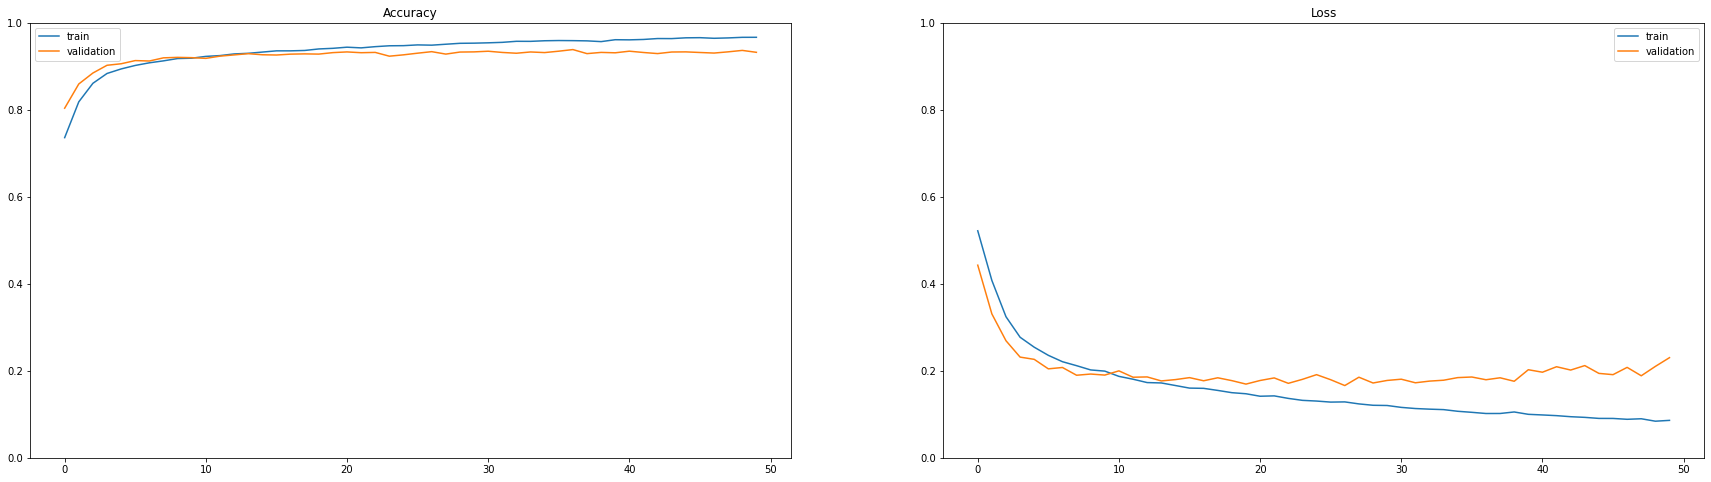

In [27]:

plt.figure(figsize=(30,8))
plt.subplot(1,2,1)
plt.ylim([0,1])
plt.plot(range(EPOCHS),total_accuracy_train,label="train")
plt.plot(range(EPOCHS),total_accuracy_val,label="validation")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.ylim([0,1])
plt.plot(range(EPOCHS),total_losses_train,label="train")
plt.plot(range(EPOCHS),total_losses_val,label="validation")
plt.legend()
plt.title("Loss")

plt.show()


**Evaluating the model**

In [33]:
model=torch.load("model.pth")
dataloader_test=torch.utils.data.DataLoader(np.arange(len(x_test)), 1000, True)
model.eval()
get_batch=iter(dataloader_test)
loss_test=[]
accuracy_test=[]
for i in get_batch:
    pred=model(x_test[i].to("cuda"))
    loss_test.append(mse(pred,y_test[i].to("cuda")).item())
    pred=pred>0.5
    target=y_test[i].to("cuda")
    correct=torch.sum(pred==target).item()
    accuracy_test.append(correct/len(y_test[i]))
accuracy_test=(np.mean(accuracy_test))
loss_test=np.mean(loss_test)
print("Accuracy test:",accuracy_test,"    loss_test:",loss_test)

Accuracy test: 0.9362999999999999     loss_test: 0.19632385224103927
